# Pipeline for Ca-Data-Preprocessing

In [1]:
# import libraries
from skimage import io
import os
import numpy as np
from PyQt5.QtWidgets import QFileDialog, QApplication

from Exp4 import *

dir = os.getcwd()
app = QApplication([dir])

In [2]:
config = {
    'working_dir': "C:\\Users\\yzhang\\Desktop\\testdata_15062022\\2022-06-15-13-02-31\\",
    'ca_filename': "rec2_neg10um_15062022_laser19_gain_620_mag1p5_jf7_5dpf_2fps_zeissobj_bulb.TIF",
    'timeline_filename': "Io.hdf5",
    'stimulus_filename': "Display.hdf5",
    'binsize': 60,
    'stepsize': 40,
    'show_motion_correction_result':False,
    'segmentation_params': {
                            'hpfiltSig': .1,
                            'localThreKerSize': 9,
                            'smoothSig': 3,
                            'binaryThre': .5,
                            'minSizeLim': 20,
                            'maxSizeLim': 500,
                            'bgKerSize': 2,
                            'fgKerSize': 1
                            },
    'show_segmentation_result': False,
    'display_traces':False,
    'save_h5': True,
}
formatted = ca_prep(config)

C:\Users\yzhang\PycharmProjects\preprocessing_arrenberg_practical_2022\Exp4.py:162: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  maxCoord = peak_local_max(smoothed_std_image, footprint=conn, indices=False, exclude_border=0)
C:\Users\yzhang\PycharmProjects\preprocessing_arrenberg_practical_2022\Exp4.py:82: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  formatted.to_hdf(save_full_path,'stim_ca_traces')
C:\Users\yzhang\PycharmProjects\preprocessing_arrenberg_practical_2022\Exp4.py:82: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->integer,key->block1_items] [items->None]

  formatted.to_hdf(save_full_pat

In [2]:
working_dir = "C:\\Users\\yzhang\\Desktop\\testdata_15062022\\2022-06-15-13-02-31\\"
ca_filename = "rec2_neg10um_15062022_laser19_gain_620_mag1p5_jf7_5dpf_2fps_zeissobj_bulb.TIF"
timeline_filename = "Io.hdf5"
stimulus_filename = "Display.hdf5"

In [3]:
# select files with calcium data (Not sure how well it works in jupyter notebook, crashed on my PC twice)
# filename_ca_data = QFileDialog.getOpenFileName(None,"Select Calcium Recording...",filter="Files(*.tif)")
# ca_movie = np.array(io.imread(filename_ca_data[0]))
# or just:
ca_movie = load_ca_movie(working_dir+ca_filename)

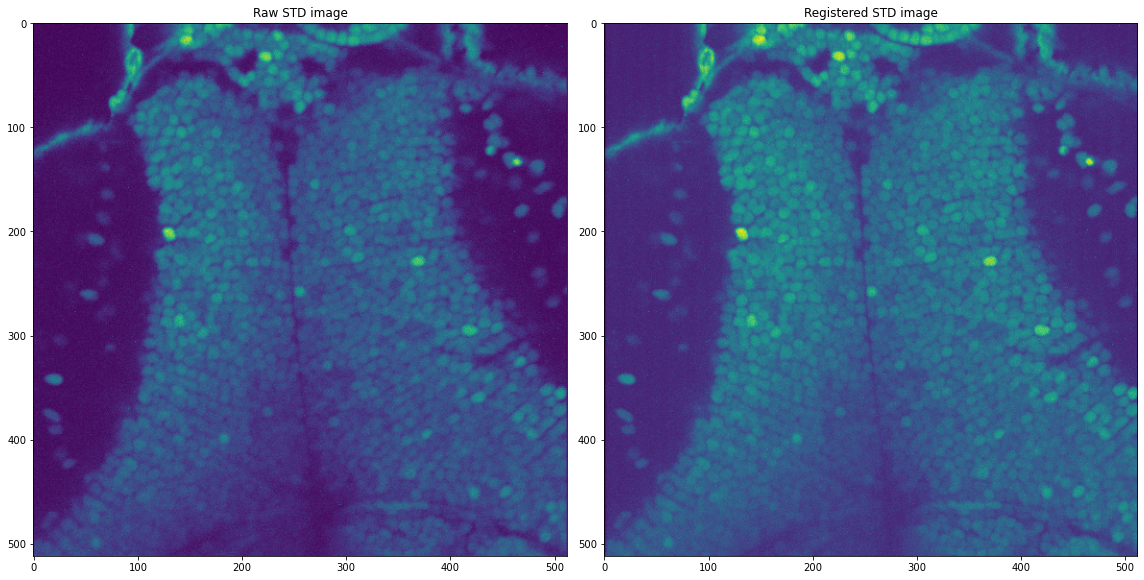

In [4]:
# registration (motion correction) of calcium frames and computation of STD image
reg_frames, std_image = motion_correction(ca_movie, binsize=60, stepsize=40)    #10, 10

C:\Users\yzhang\PycharmProjects\preprocessing_arrenberg_practical_2022\Exp4.py:87: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  maxCoord = peak_local_max(smoothed_std_image, footprint=conn, indices=False, exclude_border=0)


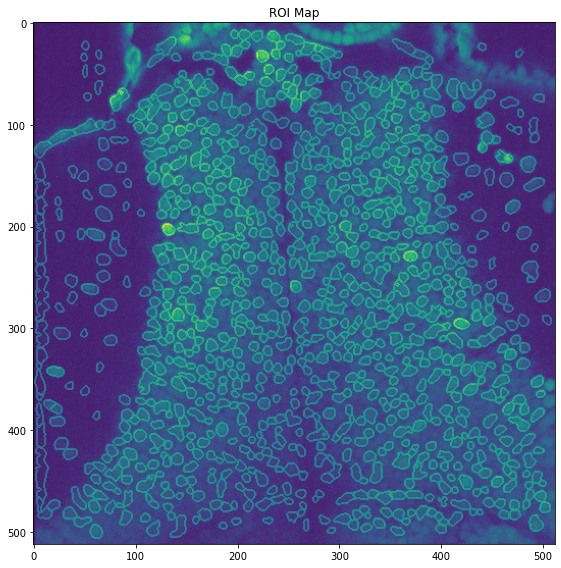

In [5]:
# cell (ROIs) segmentation with watershed algorithm
segmentation_params = {
    'hpfiltSig': .1,
    'localThreKerSize': 9,
    'smoothSig': 3,
    'binaryThre': .5,
    'minSizeLim': 20,
    'maxSizeLim': 500,
    'bgKerSize': 2,
    'fgKerSize': 1
    }
roi_mask = cell_segmentation(std_image, segmentation_params)

In [6]:
# extract calcium traces for ROIs
raw_ca_traces = extract_calcium_signals(roi_mask, reg_frames, display_traces=False)

In [8]:
# acquire stimulus parameter for each calcium frames
stim_array = align_stimulus_to_ca_frames(timefn=working_dir+timeline_file,stim_fn=working_dir+stimulus_file)

In [24]:
roi_id = np.unique(roi_mask)[1:]
formatted = pd.DataFrame(np.array(raw_ca_traces).T,columns=roi_id)
for k,v in stim_array.items():
    formatted["stim_"+k] = v

In [25]:
formatted

,1,2,3,4,5,6,7,8,9,10,...,974,975,976,977,978,979,stim_phase,stim_speed,stim_spatial_freq,stim_time
0,366863,664408,186586,264445,246007,370220,37426,275359,139875,38514,...,75203,88876,24203,134144,181688,143940,0.0,0.0,0.0,786.490711
1,294474,394843,178164,314933,302221,293741,42996,219079,149480,41139,...,80487,73182,30448,111828,191259,134014,0.0,0.0,0.0,787.190091
2,172913,422885,187447,335265,291081,357481,35473,209892,146537,48663,...,68479,90154,29967,113909,259288,151654,0.0,0.0,0.0,787.726053
3,123065,330748,117911,274467,278274,402431,35634,178644,149124,44599,...,83624,92622,36145,129467,219782,126494,0.0,0.0,0.0,788.207741
4,127518,279717,194877,377619,323129,381525,33423,135518,137696,43125,...,79846,90763,41588,122970,224589,171410,0.0,0.0,0.0,788.692878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,61692,159497,126649,259803,307635,318647,33167,155754,198783,30094,...,83561,76995,21481,101072,370191,157674,0.0,0.0,0.0,1299.884615
1045,98284,182229,123065,178932,351810,306029,36433,122039,199326,30830,...,77571,94923,40725,116568,259128,127356,0.0,0.0,0.0,1300.360335
1046,77668,149280,127200,250133,465083,295338,39475,128603,141984,39794,...,74499,79173,28590,98444,268126,145576,0.0,0.0,0.0,1300.871858
1047,97616,121497,133532,287274,334491,304453,35183,113206,168784,33136,...,51418,77473,33007,103251,235089,167666,0.0,0.0,0.0,1301.357906
